In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

data = pd.read_csv("preprocessed_apartment_rentals_one_hot_encoded_states.csv")

# Features und Ziel
X = data.drop(columns=["price", "state"])
y = data["price"]
scaler = StandardScaler()
y = scaler.fit_transform(y.values.reshape(-1, 1)).flatten()

Daten: Cityname Target encodet, States One-Hot-encoded

## 🧠 Hyperparameter des MLPRegressor (Neuronales Netz)

Der **MLPRegressor** implementiert ein Feedforward-Neuronales Netz und ist ein komplexes nichtlineares Modell. Die Parameter definieren das Suchgitter (`mlp_params`) für die Optimierung der Architektur und Regulierung in der Nested Cross-Validation.

| Parameter | Beschreibung | Im Code definierte Werte |
| :--- | :--- | :--- |
| **`hidden_layer_sizes`** | Definiert die **Architektur des Netzes**: Die Anzahl der versteckten Schichten (Hidden Layers) und die Anzahl der Neuronen pro Schicht. | `[(10, 10), (50, 50)]` |
| **`activation`** | Die **Aktivierungsfunktion** für die versteckten Schichten. Definiert die Nichtlinearität des Modells. | `["relu"]` |
| **`alpha`** | Der **L2-Regularisierungsterm** (äquivalent zu Ridge Regression). Ein höherer Wert reduziert die Komplexität und hilft, **Overfitting** zu verhindern. | `np.logspace(-5, -2, 4)` |
| **`max_iter`** | Die **maximale Anzahl von Iterationen** (Epochen), die der Optimierer über die Trainingsdaten ausführen soll. | `[500]` |

---

### 💡 Erläuterung der Netzarchitektur



[Image of a feedforward neural network architecture showing input, hidden, and output layers]


* **Netzarchitektur:** `(10, 10)` bedeutet zwei versteckte Schichten mit jeweils 10 Neuronen. `(50, 50)` bedeutet zwei versteckte Schichten mit jeweils 50 Neuronen.
* **`relu` (Rectified Linear Unit):** Sorgt dafür, dass das Netz **Nichtlinearitäten** lernen kann (d.h. komplexere Beziehungen als eine einfache lineare Regression).
* **`alpha` (Regularisierung):** Die Suche über $\text{np.logspace}(-5, -2, 4)$ testet logarithmisch verteilte Werte zwischen $10^{-5}$ und $10^{-2}$. Dies ist entscheidend, um die Modellkomplexität zu kontrollieren.
* **`max_iter`:** Da Neuronale Netze sequenziell lernen, ist ein ausreichender Wert notwendig, um die **Konvergenz** des Optimierers zu gewährleisten.

# TORCH NN

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, RegressorMixin

class TorchRegressor(BaseEstimator, RegressorMixin):    # mit Early Stopping
    def __init__(self, hidden_sizes=(64, 64), lr=1e-3, epochs=50, batch_size=64, 
                 patience=None, device=None):
        self.hidden_sizes = hidden_sizes
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.patience = patience
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        
        # Listen für Loss-Tracking
        self.train_losses = []
        self.val_losses = []

    def _build_model(self, input_dim):
        layers = []
        last = input_dim
        for h in self.hidden_sizes:
            layers.append(nn.Linear(last, h))
            layers.append(nn.ReLU())
            last = h
        layers.append(nn.Linear(last, 1))
        return nn.Sequential(*layers)

    def fit(self, X, y):
        if isinstance(X, pd.DataFrame):
            X = X.values
        if isinstance(y, pd.Series):
            y = y.values

        # 80/20 Split für Validation
        split_idx = int(0.8 * len(X))
        X_train, X_val = X[:split_idx], X[split_idx:]
        y_train, y_val = y[:split_idx], y[split_idx:]

        X_train = torch.tensor(X_train, dtype=torch.float32).to(self.device)
        y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(self.device)
        X_val = torch.tensor(X_val, dtype=torch.float32).to(self.device)
        y_val = torch.tensor(y_val, dtype=torch.float32).view(-1, 1).to(self.device)

        self.model = self._build_model(X_train.shape[1]).to(self.device)
        opt = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        loss_fn = nn.MSELoss()

        dataset = torch.utils.data.TensorDataset(X_train, y_train)
        loader = torch.utils.data.DataLoader(dataset, batch_size=self.batch_size, shuffle=True) # Mini-Batch Loader --> permutes data each epoch, all data pushed in random "packages"

        # Reset loss tracking
        self.train_losses = []
        self.val_losses = []
        
        best_val_loss = float('inf')
        patience_counter = 0

        self.model.train()
        for epoch in range(self.epochs):
            epoch_train_loss = 0.0
            num_batches = 0
            
            # Training
            for xb, yb in loader: 
                # Mini-Batch Training --> Gradient Descent Step with one batch (Batch wird durchgeschickt, loss berechnet, Gradient berechnet (Backpropagation), Gewichte upgedated)
                # Warum Mini-Batches? Effizienter als full-batch GD, stabilisiert Training, ermöglicht Training auf großen Datensätzen
                # SGD: Stochastic Gradient Descent (Batch Size = 1) --> es gibt unterschiedliche Varianten (Ziehen mit Zurücklegen, ohne Zurücklegen)
                opt.zero_grad()
                pred = self.model(xb)
                loss = loss_fn(pred, yb)
                loss.backward()
                opt.step()
                
                epoch_train_loss += loss.item()
                num_batches += 1
            
            # Durchschnittlicher Training Loss für diese Epoch
            avg_train_loss = epoch_train_loss / num_batches
            self.train_losses.append(avg_train_loss)
            
            # Validierung -- propagiert Validation Data durch das Netz, berechnet loss, aber kein Backpropagation/Weight Update
            # Loss auf Validierungsdaten wird getrackt --> falls er steigt --> Early Stopping
            self.model.eval()
            with torch.no_grad():
                val_pred = self.model(X_val)
                val_loss = loss_fn(val_pred, y_val).item()
                self.val_losses.append(val_loss)
            self.model.train()
            
            # Early stopping check (falls patience gesetzt) -- 
            if self.patience is not None:
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience_counter = 0
                else:
                    patience_counter += 1
                    if patience_counter >= self.patience:
                        print(f"Early stopping at epoch {epoch+1}/{self.epochs}")
                        break

        return self

    def predict(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.values

        self.model.eval()
        X = torch.tensor(X, dtype=torch.float32).to(self.device)
        with torch.no_grad():
            return self.model(X).cpu().numpy().ravel()
    
    def plot_losses(self, figsize=(10, 6), save_path=None):
        """
        Plottet die Training- und Validation-Loss Entwicklung.
        
        Parameters:
        -----------
        figsize : tuple, optional
            Größe der Figure (width, height)
        save_path : str, optional
            Pfad zum Speichern des Plots (z.B. 'loss_plot.png')
        """
        if not self.train_losses:
            print("Keine Loss-Daten verfügbar. Bitte erst fit() aufrufen.")
            return
        
        plt.figure(figsize=figsize)
        epochs = range(1, len(self.train_losses) + 1)
        
        plt.plot(epochs, self.train_losses, 'b-', label='Training Loss', linewidth=2)
        plt.plot(epochs, self.val_losses, 'r-', label='Validation Loss', linewidth=2)
        
        plt.xlabel('Epoch', fontsize=12)
        plt.ylabel('Loss (MSE)', fontsize=12)
        plt.title('Training vs Validation Loss', fontsize=14, fontweight='bold')
        plt.legend(fontsize=11)
        plt.grid(True, alpha=0.3)
        
        # Markiere beste Validation Loss
        best_epoch = np.argmin(self.val_losses) + 1
        best_val_loss = min(self.val_losses)
        plt.axvline(x=best_epoch, color='g', linestyle='--', alpha=0.5, 
                    label=f'Best Val Loss @ Epoch {best_epoch}')
        plt.plot(best_epoch, best_val_loss, 'g*', markersize=15)
        
        plt.legend(fontsize=10)
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Plot gespeichert unter: {save_path}")
        
        plt.show()

In [ ]:
from Nested_CV_targetEncoding import NestedCVRegressorWithTargetEncoding

torch_params = {
    "hidden_sizes": [(128, 128, 64),(512, 256, 128, 32)], # <- das war schon ganz ok R^2 0.74
    "lr": np.logspace(-7, -2, 5),
    "batch_size": [32, 64],
    "epochs": [50],
    "patience": [5, 10, 15, None] # patience gibt an, wie viele Epochen der Validierungs-Loss sich nicht verbessern (oder verschlechtern) darf, bevor das Training abgebrochen wird.
}

torch_cv = NestedCVRegressorWithTargetEncoding(TorchRegressor(), param_grid=torch_params, encode_cols=["cityname"], outer_splits=5, inner_splits=5)

print("Starte Torch Nested CV...")
torch_cv.run(X, y, output=True)

print("\n--- Torch NN Ergebnisse ---")
print("Mean R²:", torch_cv.get_mean_r2())
print("Best params:", torch_cv.get_best_params())


Starte Torch Nested CV...
Fitting 5 folds for each of 80 candidates, totalling 400 fits
Early stopping at epoch 26/50
Early stopping at epoch 22/50


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Outer Fold 1/5 | Best Params: {'model__batch_size': 32, 'model__epochs': 50, 'model__hidden_sizes': (512, 256, 128, 32), 'model__lr': np.float64(0.0005623413251903491), 'model__patience': 15} | Fit Time: 311.466s | Outer R²: 0.752 | MSE: 0.252 | Inner R²: 0.797
Fitting 5 folds for each of 80 candidates, totalling 400 fits
Early stopping at epoch 25/50
Early stopping at epoch 17/50


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Outer Fold 2/5 | Best Params: {'model__batch_size': 32, 'model__epochs': 50, 'model__hidden_sizes': (128, 128, 64), 'model__lr': np.float64(0.0005623413251903491), 'model__patience': 10} | Fit Time: 69.170s | Outer R²: 0.747 | MSE: 0.251 | Inner R²: 0.784
Fitting 5 folds for each of 80 candidates, totalling 400 fits
Early stopping at epoch 21/50
Early stopping at epoch 24/50


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Outer Fold 3/5 | Best Params: {'model__batch_size': 64, 'model__epochs': 50, 'model__hidden_sizes': (512, 256, 128, 32), 'model__lr': np.float64(0.0005623413251903491), 'model__patience': 15} | Fit Time: 118.191s | Outer R²: 0.752 | MSE: 0.248 | Inner R²: 0.799
Fitting 5 folds for each of 80 candidates, totalling 400 fits
Early stopping at epoch 21/50
Early stopping at epoch 24/50


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Outer Fold 4/5 | Best Params: {'model__batch_size': 32, 'model__epochs': 50, 'model__hidden_sizes': (512, 256, 128, 32), 'model__lr': np.float64(0.0005623413251903491), 'model__patience': 15} | Fit Time: 192.429s | Outer R²: 0.745 | MSE: 0.254 | Inner R²: 0.805
Fitting 5 folds for each of 80 candidates, totalling 400 fits
Early stopping at epoch 13/50
Early stopping at epoch 13/50


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Outer Fold 5/5 | Best Params: {'model__batch_size': 32, 'model__epochs': 50, 'model__hidden_sizes': (128, 128, 64), 'model__lr': np.float64(0.0005623413251903491), 'model__patience': 5} | Fit Time: 51.732s | Outer R²: 0.750 | MSE: 0.249 | Inner R²: 0.779

--- Torch NN Ergebnisse ---
Mean R²: 0.7493031497864748
Best params: [{'model__batch_size': 32, 'model__epochs': 50, 'model__hidden_sizes': (512, 256, 128, 32), 'model__lr': np.float64(0.0005623413251903491), 'model__patience': 15}, {'model__batch_size': 32, 'model__epochs': 50, 'model__hidden_sizes': (128, 128, 64), 'model__lr': np.float64(0.0005623413251903491), 'model__patience': 10}, {'model__batch_size': 64, 'model__epochs': 50, 'model__hidden_sizes': (512, 256, 128, 32), 'model__lr': np.float64(0.0005623413251903491), 'model__patience': 15}, {'model__batch_size': 32, 'model__epochs': 50, 'model__hidden_sizes': (512, 256, 128, 32), 'model__lr': np.float64(0.0005623413251903491), 'model__patience': 15}, {'model__batch_size': 32, '

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


In [11]:
import pandas as pd
number_outer_cv_splits = 5
model_evaluation = pd.DataFrame({"Fold": range(1, number_outer_cv_splits+1)})
model_evaluation['Modell'] = ['Torch_NN'] * number_outer_cv_splits
model_evaluation['R_2'] = torch_cv.get_r2_scores()
model_evaluation['MSE'] = torch_cv.get_mse_scores()
model_evaluation["runtime"] = torch_cv.get_fit_times()
model_evaluation

,Fold,Modell,R_2,MSE,runtime
0,1,Torch_NN,0.752059,0.251521,311.465810
1,2,Torch_NN,0.747429,0.251286,69.170410
2,3,Torch_NN,0.751573,0.248088,118.190902
3,4,Torch_NN,0.744980,0.253895,192.428898
4,5,Torch_NN,0.750475,0.248586,51.732040


In [12]:
model_evaluation.to_pickle('benchmarking/TorchNN.pkl')

-------------------------------------------------------------------------------------------------------------------------------------------
## Feature Importance


In [ ]:
#Modell vorbereiten mit besten Hyperparametern aus CV
import category_encoders as ce
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

rows_to_encode = ["cityname"]

target_encoder = ce.TargetEncoder(
    cols=rows_to_encode,
    smoothing=10
)
best_params = torch_cv.get_best_params()[0]

torch_params = {
    "hidden_sizes": [(128, 128, 64),(512, 256, 128, 32)], # <- das war schon ganz ok R^2 0.74
    "lr": np.logspace(-7, -2, 5),
    "batch_size": [32, 64],
    "epochs": [50],
    "patience": [5, 10, 15, None] # Early Stopping Geduld
}


rf_final_model = (TorchRegressor(
    hidden_sizes=best_params['model__hidden_sizes'],
    lr=best_params['model__lr'],
    batch_size=best_params['model__batch_size'],
    epochs=best_params['model__epochs'],
    patience=best_params['model__patience']
))

model_pipeline = Pipeline([
    ("target_encoding", target_encoder),
    ("model", rf_final_model)
])

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('target_encoding', TargetEncoder(cols=['cityname'])),
                ('model',
                 TorchRegressor(batch_size=32, device='cpu',
                                hidden_sizes=(512, 256, 128, 32),
                                lr=np.float64(0.0005623413251903491),
                                patience=15))])

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
c:\U

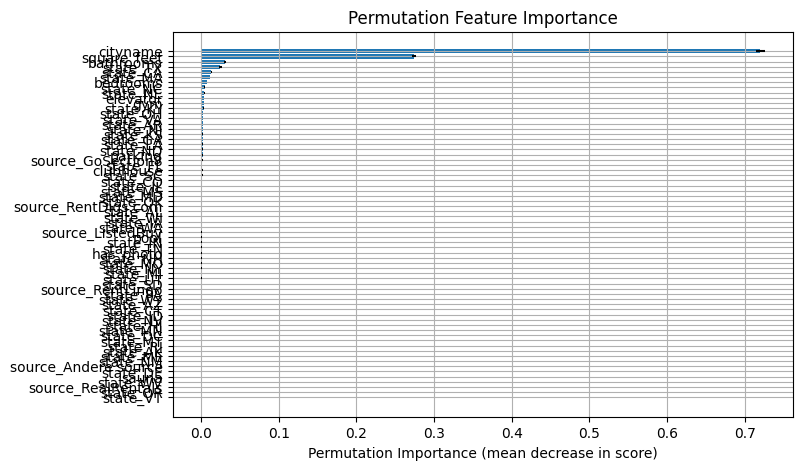

,feature,importance_mean,importance_std
63,state_VT,-2.187463e-05,0.000020
54,state_OR,-1.994591e-05,0.000017
14,source_RealRentals,-2.315601e-06,0.000095
66,state_WV,-2.634602e-07,0.000027
8,sauna,0.000000e+00,0.000000
...,...,...,...
21,state_CA,1.310128e-02,0.000583
60,state_TX,2.500815e-02,0.001655
0,bathrooms,3.066693e-02,0.001305
3,square_feet,2.747984e-01,0.002564


In [ ]:
from permutation_importance_ import permutation_importance_analysis
permutation_importance_analysis(model_pipeline, X_val, y_val, show_plot=True, save_as_pkl=True, file_name="TorchNN.pkl")